Extract YASA spindle parameters for all subjects so far (sub02 - sub07) for the adaptation nights

In [1]:
import yasa
import mne
import matplotlib.pyplot as plt
import numpy as np
import statistics
import pybv

In [2]:
# some preliminaries
datapath = 'E:\\spindle_ppTMS\\EEG'

In [60]:
def get_spindle_param(subject): 
    """ reads in continous data from the adaptation night without TMS artifacts and does automatic sleep stageing and spindle detection
    using  YASA
    input subject needs to be a string """
    
    # data_raw = mne.io.read_raw_edf((datapath + '\\' + subject + '\\' + 'ses-adapt' +'\\' + 'data_' + subject + '_clean_continous_resampled.edf'), preload=True, verbose=None)
    data_raw = mne.io.read_raw_brainvision((datapath + '\\' + subject + '\\' + 'ses-adapt' +'\\' + 'spindle-ppTMS_' + subject + '_ses-adapt.vhdr'), preload=True, verbose=None)
    data_raw = data_raw.pick_channels(["C4", "VEOG", "EMG", "HEOG", "TP9", "TP10"], ordered=False)
    data_raw.filter(0.1, 40)

    # yasa sleep stageing
    sleep_stages = yasa.SleepStaging(data_raw, eeg_name = "C4", eog_name= "VEOG", emg_name="EMG") 
    values = sleep_stages.predict() # predict the sleep stages
    hyp = yasa.Hypnogram(values, n_stages=5) # create yasa Hypnogram object
    hyp.plot_hypnogram()

    # yasa spindle detection 
    hyp_up = hyp.upsample_to_data(sf=1/30, data = data_raw)
    data_c4 = data_raw.get_data(picks=['C4'], units="uV") - data_raw.get_data(picks=['TP9'], units="uV")
    # data_c4 = data_raw.get_data(picks=['C4']) 
    # data_c4 = data_raw.get_data(picks=['C4']) - data_raw.get_data(picks=['TP9'])
    spindle_c4 = yasa.spindles_detect(data_c4, hypno=hyp_up, sf = 5000, ch_names = ['C4'], freq_sp=(10, 15), include = (2,3)) # include N2 and N3 sleep
    spindles_c4 = spindle_c4.summary()
    print(spindles_c4)

    # get RMS and spindle frequency 
    mean_RMS = statistics.mean(spindles_c4.RMS)
    print('RMS for:', subject, mean_RMS)
    mean_SpF = statistics.mean(spindles_c4.Frequency)
    print('SpF for:', subject, mean_SpF)

    return values, hyp, spindles_c4, mean_RMS, mean_SpF

In [4]:
def get_sleep_statistics(values):

    W = 0
    N1 = 0
    N2 = 0
    N3 = 0
    R = 0

    for i in values:
        if i == 'W':
            W = W + 1
        elif i == 'N1':
            N1 = N1 + 1
        elif i == 'N2':
            N2 = N2 + 1
        elif i == 'N3':
            N3 = N3 + 1
        else:
            R = R + 1

    # get part of night were subject first sleeps
    first_N1_epoch = np.where(values == "N1")[0][0] # first row, start in first column # or np.argmax(y_pred == "N1")

    # find wake epochs that were not at start/end of recording to find last sleep epoch
    if values[-1] == 'W':
        last_sleep_epoch = (np.where(values == "W")[0][-1])-1 # first raw, start in last column
    else:
        last_sleep_epoch = len(values)
        
    values_asleep = values[first_N1_epoch:last_sleep_epoch]

    A = np.count_nonzero(values_asleep == 'W') # get arousals outside of wake time and beginning and end of recording
    print(A)


    # Calculate % of total time

    perc_W_total = int(W/(W+N1+N2+N3+R)*100)
    perc_N1_total= int(N1/(W+N1+N2+N3+R)*100)
    perc_N2_total= int(N2/(W+N1+N2+N3+R)*100)
    perc_N3_total = int(N3/(W+N1+N2+N3+R)*100)
    perc_R_total = int(R/(W+N1+N2+N3+R)*100)
    perc_stages_total = [ perc_W_total, perc_N1_total, perc_N2_total, perc_N3_total, perc_R_total]


    # Calculate % of total sleep time 

    perc_A_sleep = int(A/(A+N1+N2+N3+R)*100)
    perc_N1_sleep= int(N1/(A+N1+N2+N3+R)*100)
    perc_N2_sleep = int(N2/(A+N1+N2+N3+R)*100)
    perc_N3_sleep = int(N3/(A+N1+N2+N3+R)*100)
    perc_R_sleep = int(R/(A+N1+N2+N3+R)*100)
    perc_stages_sleep = [perc_A_sleep, perc_N1_sleep, perc_N2_sleep, perc_N3_sleep, perc_R_sleep]

    # Print results
    print('The percentage of W stage total is: ' + str(perc_W_total) + '%')
    print('The percentage of N1 stage total is: ' + str(perc_N1_total) + '%')
    print('The percentage of N2 stage total is: ' + str(perc_N2_total) + '%')
    print('The percentage of N3 stage total is: ' + str(perc_N3_total) + '%')
    print('The percentage of R stage total is: ' + str(perc_R_total) + '%')

    print('The percentage of A stage asleep is: ' + str(perc_A_sleep) + '%')
    print('The percentage of N1 stage asleep is: ' + str(perc_N1_sleep) + '%')
    print('The percentage of N2 stage asleep is: ' + str(perc_N2_sleep) + '%')
    print('The percentage of N3 stage asleep is: ' + str(perc_N3_sleep) + '%')
    print('The percentage of R stage asleep is: ' + str(perc_R_sleep) + '%')

    return perc_stages_total, perc_stages_sleep

Extracting parameters from E:\spindle_ppTMS\EEG\sub-02\ses-adapt\spindle-ppTMS_sub-02_ses-adapt.vhdr...
Setting channel info structure...
Reading 0 ... 36889871  =      0.000 ...  7377.974 secs...
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 165001 samples (33.000 s)

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


c:\Users\siann\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator LabelEncoder from version 0.24.2 when using version 1.4.1.post1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
c:\Users\siann\AppData\Local\Programs\Python\Python39\lib\site-packages\yasa\hypno.py:483: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  return self.hypno.replace(self.mapping).astype(np.int16)
c:\Users\siann\AppData\Local\Programs\Python\Python39\lib\site-packages\yasa\hypno.py:483: FutureWarning: The behavior of Series.replace (and Da

        Start       Peak        End  Duration   Amplitude        RMS  \
0   1141.3372  1142.0588  1142.2100    0.8728   67.359102  14.138349   
1   1142.7372  1143.0610  1143.7010    0.9638   95.513608  17.421073   
2   1147.1556  1147.7908  1147.9932    0.8376   37.064218   8.272111   
3   1161.2110  1162.1920  1162.6932    1.4822   60.705872  13.199104   
4   1164.4668  1164.8914  1165.1596    0.6928   84.095769  17.063597   
5   1168.3688  1168.6280  1169.5902    1.2214   97.423507  19.502254   
6   1175.7344  1175.9796  1176.3874    0.6530   44.169879  10.161503   
7   1179.6936  1180.0504  1180.2242    0.5306   78.197652  17.581490   
8   1188.9386  1189.8170  1190.2874    1.3488   89.587323  16.926651   
9   1194.0742  1195.1090  1195.7242    1.6500   79.266219  13.118312   
10  1198.0012  1198.4540  1199.4896    1.4884   77.924930  15.659925   
11  1204.7542  1205.9786  1206.1506    1.3964   85.754938  16.410831   
12  1214.1128  1214.7766  1215.7368    1.6240   94.268110  16.86

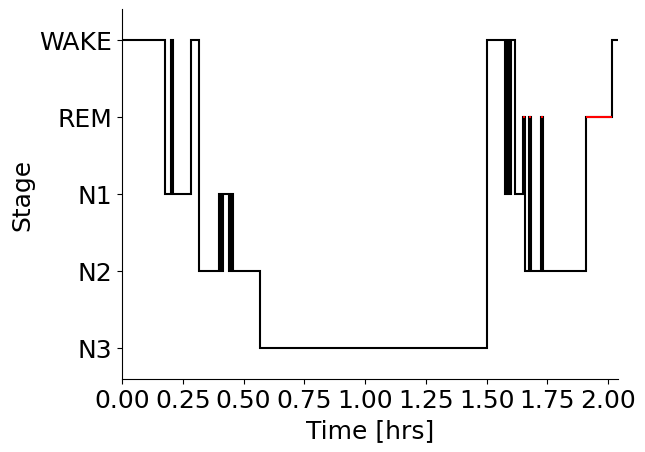

In [61]:
# print the spindle parameters for sub-02
(values_sub02, hyp_sub02, spindles_c4_sub02, mean_RMS_sub02, mean_SpF_sub02) = get_spindle_param('sub-02') 

# get sleep statistics
(perc_stages_total_sub02, perc_stages_asleep_sub02) = get_sleep_statistics(values_sub02)


Extracting parameters from E:\spindle_ppTMS\EEG\sub-03\ses-adapt\spindle-ppTMS_sub-03_ses-adapt.vhdr...
Setting channel info structure...
Reading 0 ... 38997755  =      0.000 ...  7799.551 secs...
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 165001 samples (33.000 s)

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


c:\Users\siann\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator LabelEncoder from version 0.24.2 when using version 1.4.1.post1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
c:\Users\siann\AppData\Local\Programs\Python\Python39\lib\site-packages\yasa\hypno.py:483: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  return self.hypno.replace(self.mapping).astype(np.int16)
c:\Users\siann\AppData\Local\Programs\Python\Python39\lib\site-packages\yasa\hypno.py:483: FutureWarning: The behavior of Series.replace (and Da

         Start       Peak        End  Duration  Amplitude        RMS  \
0     917.4776   917.9508   918.1770    0.6994  72.037932  13.813845   
1    1071.6858  1072.3106  1072.8640    1.1782  42.648585   8.920034   
2    1119.4498  1119.7292  1119.9984    0.5486  38.494841   9.597972   
3    1129.6256  1130.2692  1131.1278    1.5022  45.971536   8.299572   
4    1137.7028  1138.3892  1138.4842    0.7814  48.059418   8.547926   
..         ...        ...        ...       ...        ...        ...   
114  7527.1318  7527.4380  7527.9730    0.8412  34.225194   7.643309   
115  7563.1822  7563.5236  7563.6912    0.5090  26.631824   6.472369   
116  7613.9098  7614.5082  7614.8476    0.9378  44.521111   8.277573   
117  7628.8516  7628.9716  7629.4004    0.5488  23.292694   5.029962   
118  7682.6364  7683.3304  7683.5150    0.8786  31.290080   5.835169   

     AbsPower  RelPower  Frequency  Oscillations  Symmetry  Stage Channel  \
0    2.131662  0.340749  12.883580           8.0  0.676387

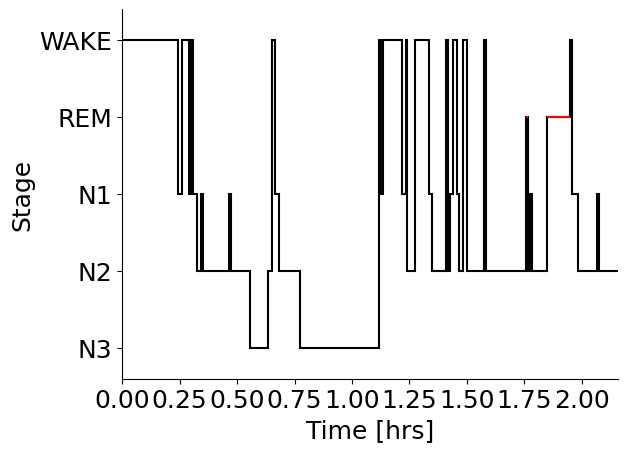

In [39]:
# get the spindle parameters for sub-03
(values_sub03, hyp_sub03, spindles_c4_sub03, mean_RMS_sub03, mean_SpF_sub03) = get_spindle_param('sub-03') 

# get sleep statistics
(perc_stages_total_sub03, perc_stages_asleep_sub03) = get_sleep_statistics(values_sub03)

Extracting parameters from E:\spindle_ppTMS\EEG\sub-04\ses-adapt\spindle-ppTMS_sub-04_ses-adapt.vhdr...
Setting channel info structure...
Reading 0 ... 35697506  =      0.000 ...  7139.501 secs...
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 165001 samples (33.000 s)

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


c:\Users\siann\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator LabelEncoder from version 0.24.2 when using version 1.4.1.post1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
c:\Users\siann\AppData\Local\Programs\Python\Python39\lib\site-packages\yasa\hypno.py:483: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  return self.hypno.replace(self.mapping).astype(np.int16)
c:\Users\siann\AppData\Local\Programs\Python\Python39\lib\site-packages\yasa\hypno.py:483: FutureWarning: The behavior of Series.replace (and Da

         Start       Peak        End  Duration   Amplitude        RMS  \
0     678.0814   678.5956   678.7958    0.7144  151.683830  28.728918   
1     725.0716   725.9708   726.4524    1.3808  121.862202  24.568186   
2     745.4036   745.7120   746.5562    1.1526  174.398878  32.111622   
3     753.9400   754.1874   754.6488    0.7088   72.660529  17.262664   
4     791.9058   792.3368   792.6010    0.6952   71.026324  15.234365   
..         ...        ...        ...       ...         ...        ...   
533  7060.2530  7060.7820  7061.0304    0.7774   96.486922  23.725255   
534  7079.6894  7080.1160  7080.4406    0.7512   66.339461  17.012819   
535  7097.7228  7098.8496  7099.6960    1.9732   97.267557  18.191111   
536  7108.0888  7108.4046  7108.8176    0.7288  101.093671  23.085218   
537  7116.4694  7116.8224  7117.0002    0.5308  114.323606  22.376625   

     AbsPower  RelPower  Frequency  Oscillations  Symmetry  Stage Channel  \
0    2.529632  0.258030  13.048154           9

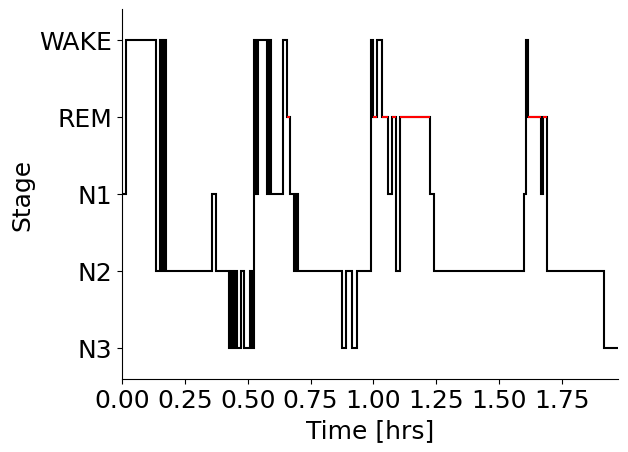

In [57]:
# get the spindle parameters for sub-04
(values_sub04, hyp_sub04, spindles_c4_sub04, mean_RMS_sub04, mean_SpF_sub04) = get_spindle_param('sub-04') 

# get sleep statistics
(perc_stages_total_sub04, perc_stages_asleep_sub04) = get_sleep_statistics(values_sub04)

Extracting parameters from E:\spindle_ppTMS\EEG\sub-05\ses-adapt\spindle-ppTMS_sub-05_ses-adapt.vhdr...
Setting channel info structure...
Reading 0 ... 43809497  =      0.000 ...  8761.899 secs...
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 165001 samples (33.000 s)

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


c:\Users\siann\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator LabelEncoder from version 0.24.2 when using version 1.4.1.post1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
c:\Users\siann\AppData\Local\Programs\Python\Python39\lib\site-packages\yasa\hypno.py:483: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  return self.hypno.replace(self.mapping).astype(np.int16)
c:\Users\siann\AppData\Local\Programs\Python\Python39\lib\site-packages\yasa\hypno.py:483: FutureWarning: The behavior of Series.replace (and Da

         Start       Peak        End  Duration  Amplitude        RMS  \
0    1415.2390  1415.3838  1416.2106    0.9716  32.747780   6.303598   
1    1473.8216  1474.2834  1474.4460    0.6244  55.511718  11.437306   
2    1755.8426  1756.0832  1756.4654    0.6228  64.947153  13.179855   
3    1761.5796  1762.0284  1762.7010    1.1214  52.335978  10.444285   
4    1902.3296  1903.0120  1903.2934    0.9638  68.580800  13.949102   
..         ...        ...        ...       ...        ...        ...   
98   7616.4618  7616.7148  7617.0502    0.5884  47.646433  10.391134   
99   7710.3438  7710.7862  7711.4032    1.0594  87.773897  19.253128   
100  7719.3382  7719.7772  7720.0436    0.7054  47.718037   9.625153   
101  7722.8046  7722.9192  7723.9092    1.1046  59.943598  10.972723   
102  7998.0298  7998.3344  7998.6086    0.5788  51.351057  10.712903   

     AbsPower  RelPower  Frequency  Oscillations  Symmetry  Stage Channel  \
0    1.421690  0.317044  12.334752          12.0  0.149002

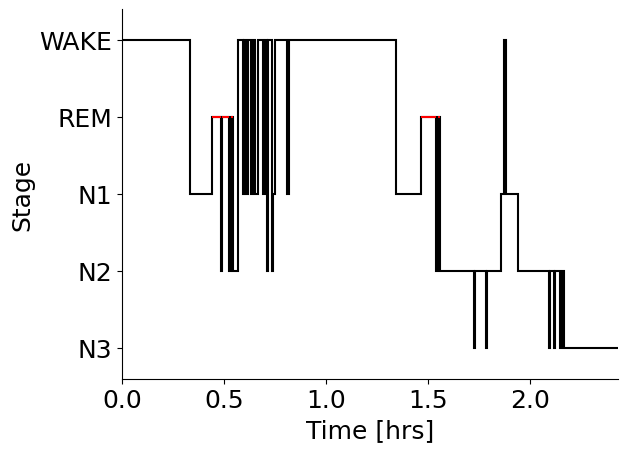

In [58]:
(values_sub05, hyp_sub05, spindles_c4_sub05, mean_RMS_sub05, mean_SpF_sub05) = get_spindle_param('sub-05') 

# get sleep statistics
(perc_stages_total_sub05, perc_stages_asleep_sub05) = get_sleep_statistics(values_sub05)

Extracting parameters from E:\spindle_ppTMS\EEG\sub-07\ses-adapt\spindle-ppTMS_sub-07_ses-adapt.vhdr...
Setting channel info structure...
Reading 0 ... 33893012  =      0.000 ...  6778.602 secs...
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 165001 samples (33.000 s)

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


c:\Users\siann\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator LabelEncoder from version 0.24.2 when using version 1.4.1.post1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
c:\Users\siann\AppData\Local\Programs\Python\Python39\lib\site-packages\yasa\hypno.py:483: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  return self.hypno.replace(self.mapping).astype(np.int16)
c:\Users\siann\AppData\Local\Programs\Python\Python39\lib\site-packages\yasa\hypno.py:483: FutureWarning: The behavior of Series.replace (and Da

         Start       Peak        End  Duration   Amplitude        RMS  \
0     365.4676   366.2864   366.6392    1.1716   50.224738   9.377684   
1     399.8892   400.3382   400.3896    0.5004   54.783381  11.384261   
2     413.1680   413.4940   413.7678    0.5998   47.281671  10.934129   
3     518.9248   519.3946   519.5252    0.6004   35.724914   8.462932   
4     534.0400   534.1442   534.6310    0.5910   45.845163   9.773057   
..         ...        ...        ...       ...         ...        ...   
110  6434.3718  6434.5560  6435.5112    1.1394  133.154224  25.630163   
111  6446.8610  6447.2336  6447.6230    0.7620  265.150924  47.438050   
112  6629.5294  6629.7466  6630.0314    0.5020   47.471266  10.743300   
113  6680.1016  6680.8700  6681.3994    1.2978   60.402871  11.472859   
114  6709.2854  6709.4840  6710.3374    1.0520   55.638434  10.470865   

     AbsPower  RelPower  Frequency  Oscillations  Symmetry  Stage Channel  \
0    1.947183  0.403817  11.308388          12

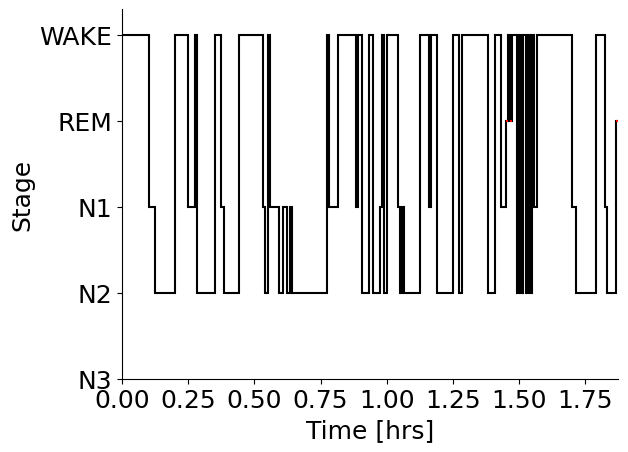

In [59]:
(values_sub07, hyp_sub07, spindles_c4_sub07, mean_RMS_sub07, mean_SpF_sub07) = get_spindle_param('sub-07') 

# get sleep statistics
(perc_stages_total_sub07, perc_stages_asleep_sub07) = get_sleep_statistics(values_sub07)